In [1]:
import os
import pandas as pd
import numpy as np
import zipfile

In [2]:
data_path = f"Data"
raw_data = os.path.join(data_path, f"Raw Data")
preprocess_path = os.path.join(data_path, f"Preprocessed Data")

# FIPS

In [3]:
counties = pd.read_csv(os.path.join(preprocess_path, f"Selected_Counties.csv"))

In [4]:
continuum_codes = pd.read_excel(os.path.join(raw_data, f"Ruralurbancontinuumcodes2023.xlsx"), sheet_name="Rural-urban Continuum Code 2023", dtype={'FIPS': str})

In [5]:
continuum_codes.head()

,FIPS,State,County_Name,Population_2020,RUCC_2023,Description
0,01001,AL,Autauga County,58805,2.0,"Metro - Counties in metro areas of 250,000 to ..."
1,01003,AL,Baldwin County,231767,3.0,Metro - Counties in metro areas of fewer than ...
2,01005,AL,Barbour County,25223,6.0,"Nonmetro - Urban population of 5,000 to 20,000..."
3,01007,AL,Bibb County,22293,1.0,Metro - Counties in metro areas of 1 million p...
4,01009,AL,Blount County,59134,1.0,Metro - Counties in metro areas of 1 million p...


In [6]:
results = []
for index1, row1 in counties.iterrows():
    state = row1['State']
    county_name = row1['Counties 1']
    if not pd.isna(county_name):
        continuum_codes_state = continuum_codes[continuum_codes['State'] == state]
        for index2, row2 in continuum_codes_state.iterrows():
            if county_name in row2['County_Name']:
                results.append({
                    'State': state,
                    'County': str(row2['County_Name']),
                    'RUCC': row2['RUCC_2023'],
                    'FIPS': row2['FIPS'],
                    'State Code': row2['FIPS'][:2],
                    'County Code': row2['FIPS'][2:]
                })
                continue
        
fips = pd.DataFrame(results)

In [7]:
fips.to_csv(os.path.join(preprocess_path, "FIPS.csv"), index=False)

# State, County Code

In [8]:
state_county_code = pd.read_excel(os.path.join(raw_data, f'2020_UA_COUNTY.xlsx'), sheet_name='2020_UA_COUNTY', dtype={'STATE': str, 'COUNTY': str})

In [9]:
state_county_code.head()

,STATE,COUNTY,STATE_NAME,COUNTY_NAME,POP_COU,HOU_COU,ALAND_COU,ALAND_Mi²_COU,POPDEN_COU,HOUDEN_COU,...,POP_RUR,POPPCT_RUR,HOU_RUR,HOUPCT_RUR,ALAND_RUR,ALAND_Mi²_RUR,ALAND_PCT_RUR,POPDEN_RUR,HOUDEN_RUR,RURALBLOCKS
0,01,001,Alabama,Autauga,58805,24350,1539634184,594.452758,98.922916,40.962044,...,23920,0.406768,9991,0.410308,1483727020,572.867002,0.963688,41.754892,17.440348,991
1,01,003,Alabama,Baldwin,231767,124148,4117656199,1589.827058,145.781265,78.088997,...,87113,0.375865,40740,0.328157,3762600021,1452.739868,0.913772,59.964624,28.043562,3181
2,01,005,Alabama,Barbour,25223,11618,2292160149,885.003034,28.500467,13.127639,...,16627,0.659200,7538,0.648821,2276027730,878.774307,0.992962,18.920672,8.577857,1011
3,01,007,Alabama,Bibb,22293,9002,1612188717,622.466064,35.814001,14.461833,...,22293,1.000000,9002,1.000000,1612188717,622.466064,1.000000,35.814001,14.461833,1090
4,01,009,Alabama,Blount,59134,24622,1670259090,644.887035,91.696680,38.180330,...,53510,0.904894,22337,0.907197,1658933117,640.514076,0.993219,83.542270,34.873551,2207


In [10]:
state_county_names = pd.merge(fips, state_county_code, left_on=['State Code', 'County Code'], right_on=['STATE', 'COUNTY'], how='inner')
state_county_names.rename(columns={'STATE_NAME': 'State Name', 'COUNTY_NAME': 'County Name', 'State': 'State Name Code', 'County': 'County Full Name'}, inplace=True)
state_county_names = state_county_names[['State Code', 'County Code', 'FIPS', 'State Name', 'County Name', 'RUCC', 'State Name Code', 'County Full Name']]

In [11]:
state_county_names.head()

,State Code,County Code,FIPS,State Name,County Name,RUCC,State Name Code,County Full Name
0,06,037,06037,California,Los Angeles,1.0,CA,Los Angeles County
1,06,029,06029,California,Kern,2.0,CA,Kern County
2,06,025,06025,California,Imperial,3.0,CA,Imperial County
3,06,033,06033,California,Lake,4.0,CA,Lake County
4,06,023,06023,California,Humboldt,5.0,CA,Humboldt County


# Population Estimates

In [12]:
population_2018_2019_df = pd.read_csv(os.path.join(raw_data, "co-est2020-alldata.csv"), encoding = "ISO-8859-1", dtype={'STATE': str, 'COUNTY':str})
population_2018_2019_df_sub = population_2018_2019_df[['STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'POPESTIMATE2018', 'POPESTIMATE2019']].copy()
population_2018_2019_df_sub.rename(columns={'STNAME': 'State Name', 'CTYNAME': 'County Name', 'STATE': 'State Code', 'COUNTY': 'County Code'}, inplace=True)

In [13]:
population_2020_2023_df = pd.read_csv(os.path.join(raw_data, "co-est2023-alldata.csv"), encoding = "ISO-8859-1", dtype={'STATE': str, 'COUNTY':str})
population_2020_2023_df_sub = population_2020_2023_df[['STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'POPESTIMATE2020', 'POPESTIMATE2021', 'POPESTIMATE2022', 'POPESTIMATE2023']].copy()
population_2020_2023_df_sub.rename(columns={'STNAME': 'State Name', 'CTYNAME': 'County Name', 'STATE': 'State Code', 'COUNTY': 'County Code'}, inplace=True)

In [14]:
population_2018_2023_df = pd.merge(population_2018_2019_df_sub, population_2020_2023_df_sub, left_on=['State Code', 'County Code'], right_on=['State Code', 'County Code'], how='inner')
population_2018_2023_df.rename(columns={'State Name_x': 'State Name', 'County Name_x': 'County Name'}, inplace=True)
population_2018_2023_df_sub = population_2018_2023_df[['State Code', 'County Code', 'State Name', 'County Name', 'POPESTIMATE2018', 'POPESTIMATE2019', 'POPESTIMATE2020', 'POPESTIMATE2021', 'POPESTIMATE2022', 'POPESTIMATE2023']]

In [15]:
population_2018_2023_df_sub.head()

,State Code,County Code,State Name,County Name,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022,POPESTIMATE2023
0,01,000,Alabama,Alabama,4891628,4907965,5031864,5050380,5073903,5108468
1,01,001,Alabama,Autauga County,55533,55769,58915,59203,59726,60342
2,01,003,Alabama,Baldwin County,218071,223565,233227,239439,246531,253507
3,01,005,Alabama,Barbour County,24887,24657,24969,24533,24700,24585
4,01,007,Alabama,Bibb County,22300,22313,22188,22359,21986,21868


In [16]:
population_stacked = population_2018_2023_df_sub.melt(id_vars=['State Code', 'County Code', 'State Name', 'County Name'],
                    value_vars=['POPESTIMATE2018', 'POPESTIMATE2019', 'POPESTIMATE2020', 
                                'POPESTIMATE2021', 'POPESTIMATE2022', 'POPESTIMATE2023'],
                    var_name='Year', value_name='Population')

# Extracting the year from the 'Year' column
population_stacked['Year'] = population_stacked['Year'].str.extract(r'(\d{4})').astype(int)

In [17]:
population_sub = pd.merge(population_stacked, state_county_names, left_on=['State Code', 'County Code'], right_on=['State Code', 'County Code'], how='inner')
population_sub.rename(columns={'State Name_x': 'State Name', 'County Name_y': 'County Name'}, inplace=True)

In [18]:
population_sub.head()

,State Code,County Code,State Name,County Name_x,Year,Population,FIPS,State Name_y,County Name,RUCC,State Name Code,County Full Name
0,06,021,California,Glenn County,2018,27899,06021,California,Glenn,6.0,CA,Glenn County
1,06,021,California,Glenn County,2019,28445,06021,California,Glenn,6.0,CA,Glenn County
2,06,021,California,Glenn County,2020,28904,06021,California,Glenn,6.0,CA,Glenn County
3,06,021,California,Glenn County,2021,28718,06021,California,Glenn,6.0,CA,Glenn County
4,06,021,California,Glenn County,2022,28360,06021,California,Glenn,6.0,CA,Glenn County


In [19]:
population_df = population_sub[['State Code', 'County Code', 'FIPS', 'State Name', 'County Name', 'RUCC', 'State Name Code', 'County Full Name', 'Year', 'Population']].copy()

In [20]:
population_df.head()

,State Code,County Code,FIPS,State Name,County Name,RUCC,State Name Code,County Full Name,Year,Population
0,06,021,06021,California,Glenn,6.0,CA,Glenn County,2018,27899
1,06,021,06021,California,Glenn,6.0,CA,Glenn County,2019,28445
2,06,021,06021,California,Glenn,6.0,CA,Glenn County,2020,28904
3,06,021,06021,California,Glenn,6.0,CA,Glenn County,2021,28718
4,06,021,06021,California,Glenn,6.0,CA,Glenn County,2022,28360


# Annual AQI Data

In [21]:
years = range(2018, 2024, 1)
zip_files = [f'annual_aqi_by_county_{year}' for year in years]

# Initialize an empty list to store dataframes
df_list = []

for year in years:
    zip_file_name = os.path.join(raw_data, f'annual_aqi_by_county_{year}.zip')

    with zipfile.ZipFile(zip_file_name, 'r') as z:
        csv_file = z.namelist()[0]
        with z.open(csv_file) as f:
            df = pd.read_csv(f)
            df_list.append(df)

merged_aqi = pd.concat(df_list, ignore_index=True)
merged_aqi.to_csv(os.path.join(preprocess_path, 'merged_aqi_by_county_2018_2023.csv'), index=False)

In [22]:
merged_aqi_pops = pd.merge(merged_aqi, population_df, left_on=['State', 'County', 'Year'], right_on=['State Name', 'County Name', 'Year'], how='inner')

In [23]:
merged_aqi_pops.to_csv(os.path.join(preprocess_path, "merged_aqi_county.csv"), index=False)

In [23]:
merged_aqi_pops.head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,...,Days PM10,State Code,County Code,FIPS,State Name,County Name,RUCC,State Name Code,County Full Name,Population
0,California,Glenn,2018,363,275,72,9,6,1,0,...,73,06,021,06021,California,Glenn,6.0,CA,Glenn County,27899
1,California,Humboldt,2018,365,324,35,5,1,0,0,...,18,06,023,06023,California,Humboldt,5.0,CA,Humboldt County,136502
2,California,Imperial,2018,365,95,220,41,7,2,0,...,129,06,025,06025,California,Imperial,3.0,CA,Imperial County,181062
3,California,Kern,2018,365,65,170,103,27,0,0,...,13,06,029,06029,California,Kern,2.0,CA,Kern County,893618
4,California,Lake,2018,357,347,7,1,1,1,0,...,2,06,033,06033,California,Lake,4.0,CA,Lake County,64394


In [24]:
merged_aqi_pops.columns

Index(['State', 'County', 'Year', 'Days with AQI', 'Good Days',
       'Moderate Days', 'Unhealthy for Sensitive Groups Days',
       'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Max AQI',
       '90th Percentile AQI', 'Median AQI', 'Days CO', 'Days NO2',
       'Days Ozone', 'Days PM2.5', 'Days PM10', 'State Code', 'County Code',
       'FIPS', 'State Name', 'County Name', 'RUCC', 'State Name Code',
       'County Full Name', 'Population'],
      dtype='object')

In [25]:
aqi_data = merged_aqi_pops[['State', 'County', 'Year', 'RUCC', 'Population', 'Max AQI', '90th Percentile AQI', 'Median AQI']]

In [26]:
aqi_data.to_csv(os.path.join(preprocess_path, "aqi_data.csv"), index=False)

In [27]:
aqi_data.shape

(127, 8)

# Correlation

#### RUCC-wise Correlation Across Years (Median AQI)

In [28]:
# Group the data by RUCC and Year, then calculate the average Median AQI and average Population for each group
df_grouped_avg = merged_aqi_pops.groupby(['RUCC', 'Year']).agg({
    'Median AQI': 'median',
    'Population': 'mean'
}).reset_index()
 
# Calculate correlation between average Max AQI and population for each RUCC
correlation_results_filtered = {}
 
for rucc in df_grouped_avg['RUCC'].unique():
    df_rucc = df_grouped_avg[df_grouped_avg['RUCC'] == rucc]
    correlation = df_rucc['Median AQI'].corr(df_rucc['Population'])
    correlation_results_filtered[rucc] = correlation
 
correlation_filtered_df = pd.DataFrame.from_dict(correlation_results_filtered, orient='index', columns=['Correlation'])
 
print(correlation_filtered_df)

     Correlation
1.0    -0.407594
2.0    -0.479369
3.0    -0.727848
4.0     0.800516
5.0     0.278602
6.0    -0.699233
7.0    -0.733471
8.0    -0.188069
9.0     0.880496


#### RUCC-wise Correlation Per Year (Max AQI)

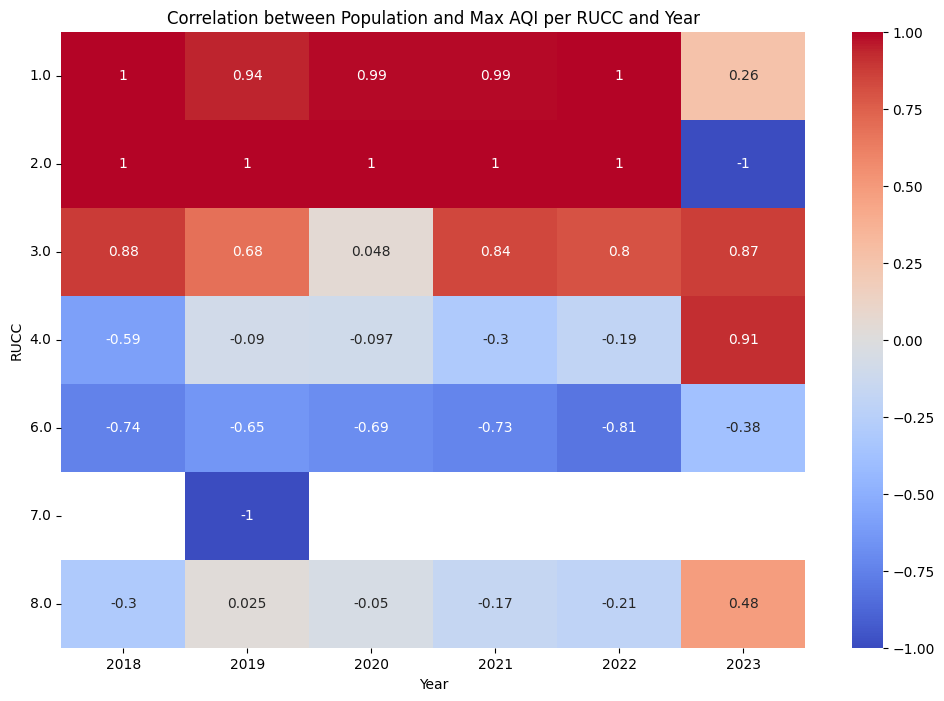

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Including RUCC in the filtered data
relevant_columns = ['State', 'Year', 'Population', 'Max AQI', 'RUCC']
data_filtered = merged_aqi_pops[relevant_columns]

# Excluding RUCC 5.0 and 9.0 from the filtered data
data_filtered = data_filtered[~data_filtered['RUCC'].isin([5.0, 9.0])]

# Grouping by RUCC and Year, and then calculating the correlation between Population and Max AQI
correlation_data_rucc = data_filtered.groupby(['RUCC', 'Year']).corr().reset_index()

# Extracting only the correlations of interest
correlation_data_rucc = correlation_data_rucc[correlation_data_rucc['level_2'] == 'Population'][['RUCC', 'Year', 'Max AQI']]

# Pivoting the dataframe for heatmap
heatmap_data_rucc = correlation_data_rucc.pivot("RUCC", "Year", "Max AQI")

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_rucc, annot=True, cmap="coolwarm", center=0)
plt.title('Correlation between Population and Max AQI per RUCC and Year')
plt.yticks(rotation=0)
plt.show()


In [ ]:
# merged_with_correlation = pd.merge(data_filtered, correlation_data_rucc.rename(columns={'Max AQI': 'VMT_Correlation'}), on=['RUCC', 'Year'], how='left')

In [32]:
# Renaming the column for clarity
correlation_data_rucc.rename(columns={'Max AQI': 'Correlation'}, inplace=True)

# Merging the correlation data back into the original dataframe
merged_with_correlation = pd.merge(data_filtered, correlation_data_rucc, on=['RUCC', 'Year'], how='left')

In [33]:
merged_with_correlation.head()

,State,Year,Population,Max AQI,RUCC,Correlation
0,California,2018,27899,230,6.0,-0.742395
1,California,2018,181062,286,3.0,0.882188
2,California,2018,893618,190,2.0,1.000000
3,California,2018,64394,208,4.0,-0.588894
4,California,2018,10061533,201,1.0,0.998291


In [34]:
merged_with_correlation.to_csv(os.path.join(preprocess_path, "merged_q1_with_correlation.csv"), index=False)

#### State-wise Correlation Across Years (Median AQI)

In [34]:
# Group the data by RUCC and Year, then calculate the average Median AQI and average Population for each group
df_grouped_avg = merged_aqi_pops.groupby(['State', 'Year']).agg({
    'Median AQI': 'median',
    'Population': 'mean'
}).reset_index()
 
# Calculate correlation between average Max AQI and population for each RUCC
correlation_results_filtered = {}
 
for state in df_grouped_avg['State'].unique():
    df_state = df_grouped_avg[df_grouped_avg['State'] == state]
    correlation = df_state['Median AQI'].corr(df_state['Population'])
    correlation_results_filtered[state] = correlation
 
correlation_filtered_df = pd.DataFrame.from_dict(correlation_results_filtered, orient='index', columns=['Correlation'])
 
print(correlation_filtered_df)

              Correlation
California       0.155208
Nebraska        -0.390439
New York        -0.140121
Pennsylvania    -0.874369
Texas           -0.271701


#### State-wise Correlation Per Year (Max AQI)

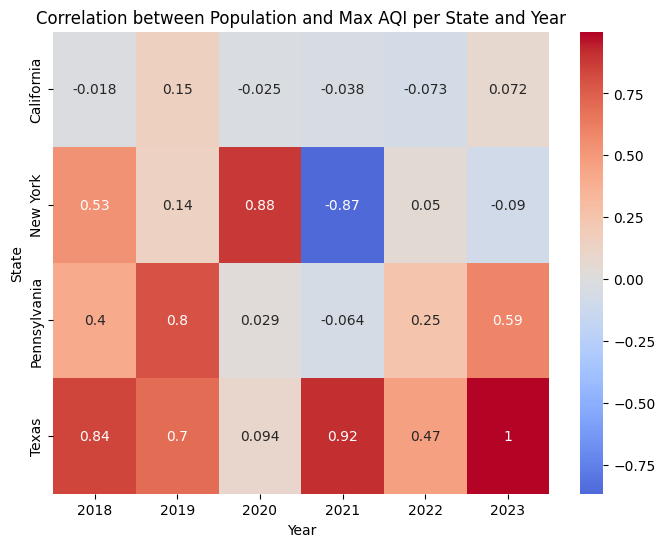

In [35]:
data_filtered = merged_aqi_pops[relevant_columns]

# Grouping by State and Year, and then calculating the correlation between Population and Max AQI
correlation_data = data_filtered.groupby(['State', 'Year']).corr().reset_index()

# Extracting only the correlations of interest
correlation_data = correlation_data[correlation_data['level_2'] == 'Population'][['State', 'Year', 'Max AQI']]

# Removing Nebraska from the analysis
correlation_data = correlation_data[correlation_data['State'] != 'Nebraska']

# Pivoting the dataframe for heatmap
heatmap_data = correlation_data.pivot("State", "Year", "Max AQI")

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0)
plt.title('Correlation between Population and Max AQI per State and Year')
plt.show()
